# Metrics of Fine tuning ResNeXt-101 without augmented images

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.insert(0, "./../../../src/utils/")
from utils import winapi_path

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
data_dir = "./../../../data/model_learning/"
scores_dir = data_dir + "scores/"
losses_dir = data_dir + "losses/"
lr_dir = data_dir + "learning_rates/"

scores_folder = "scores_resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_without-aug-images"
losses_folder = "losses_resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_without-aug-images"
lr_folder = "lr_resnext-101_280_batch-4_adam_e-6_steplr_10-0.1_Marg-0.7_triplets-10_without-aug-images"
train_param = "Resnext-101, 280 res, Batch 4, adam_e-6, steplr_10-0.1, Loss Marg-0.7, 10 triplets, without aug images"

In [2]:
def read_losses_scores_lr(curr_losses_folder, curr_scores_folder, curr_lr_folder, split_id):
    
    if split_id:
        curr_scores_folder = curr_scores_folder + "_v" + str(split_id) + "/"
        curr_losses_folder = curr_losses_folder + "_v" + str(split_id) + "/"
        curr_lr_folder = curr_lr_folder + "_v" + str(split_id) + "/"
    else:    
        curr_scores_folder = curr_scores_folder + "/"
        curr_losses_folder = curr_losses_folder + "/"
        curr_lr_folder = curr_lr_folder + "/"
        
    
    train_loss = pd.read_csv(winapi_path(losses_dir + curr_losses_folder + "train_loss.csv"))
    val_loss = pd.read_csv(winapi_path(losses_dir + curr_losses_folder + "validation_loss.csv"))


    train_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "train_scores.csv"))
    val_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "validation_scores.csv"))
    test_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "test_scores.csv"))
    non_train_scores = pd.read_csv(winapi_path(scores_dir + curr_scores_folder + "test-and-val_scores.csv"))
    
    learning_rates = pd.read_csv(winapi_path(lr_dir + curr_lr_folder + "learning_rate.csv"))
    
    return train_loss, val_loss, train_scores, val_scores, test_scores, non_train_scores, learning_rates


def highlight_df_scores(score_df):
    return (score_df.style.highlight_min(color = 'lightgreen', axis = 0, subset=['mean_position','mean_min_position', 'mean_median_position'])
 .highlight_max(color = 'lightblue', axis = 0, subset=['map','recall_400', 'recall_200', 'recall_100', 'recall_50', 'recall_20']))


def plot_mean_position(train_df, val_df, test_df, test_val_df, train_param):
    plts = plt.figure(figsize=(9, 6))
    plt.plot(train_df['mean_position'], label="train")
    if val_df is not None:
        plt.plot(val_df['mean_position'], label="validation")
    if test_df is not None:
        plt.plot(test_df['mean_position'], label="test")
    if test_val_df is not None:
        plt.plot(test_val_df['mean_position'], label="Non-Train")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Position of retrived artwork")
    plt.legend()
    plt.title("Average position of the expected artwork in the list of retrived artworks")
    plt.suptitle(train_param)
    plt.grid()
    plts.tight_layout()
    
    
def plot_recall_at_k(train_df, val_df, test_df, test_val_df, train_param, recall_columns = ['recall_400', 'recall_200', 'recall_100', 'recall_50', 'recall_20']):

    plts = plt.figure(figsize=(15, 9))
    ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2, fig=plts)
    ax2 = plt.subplot2grid((2,6), (0,2), colspan=2, fig=plts, sharey=ax1)
    ax3 = plt.subplot2grid((2,6), (0,4), colspan=2, fig=plts, sharey=ax1)
    ax4 = plt.subplot2grid((2,6), (1,1), colspan=2, fig=plts, sharey=ax1)
    ax5 = plt.subplot2grid((2,6), (1,3), colspan=2, fig=plts, sharey=ax1)

    axs = [ax1, ax2, ax3, ax4, ax5]

    for num, name in enumerate(recall_columns):

        axs[num].plot(train_df[name], label="train")
        axs[num].plot(val_df[name], label="validation")
        axs[num].plot(test_df[name], label="test")
        if test_val_df is not None:
            axs[num].plot(test_val_df[name], label="non-train")
        axs[num].set_xlabel("Epoch")
        axs[num].set_ylabel(name)
        axs[num].legend()
        axs[num].set_title(name.replace("_", "@").replace("recall", "Recall"))
        axs[num].grid()


    plts.suptitle("{}\nRecall@k".format(train_param))
    plt.yticks(np.linspace(0, 1, 11))
    plt.margins(x=0.02)
    plts.tight_layout()
    
    
def get_averaged_df(score_dataframe):
    a = score_dataframe.groupby("model").agg(['mean', 'std'])
    a.columns = list(map('_'.join, a.columns.values))
    a["MP"] = round(a["MP_mean"], 2).astype(str) + " ± " + round(a["MP_std"], 2).astype(str)
    a["MMP"] = round(a["MMP_mean"], 2).astype(str) + " ± " + round(a["MMP_std"], 2).astype(str)
    a["mean_median_position"] = round(a["mean_median_position_mean"], 2).astype(str) + " ± " + round(a["mean_median_position_std"], 2).astype(str)
    a["MAP"] = round(a["MAP_mean"], 2).astype(str) + " ± " + round(a["MAP_std"], 2).astype(str)
    a["R@400"] = round(a["R@400_mean"], 2).astype(str) + " ± " + round(a["R@400_std"], 2).astype(str)
    a["R@200"] = round(a["R@200_mean"], 2).astype(str) + " ± " + round(a["R@200_std"], 2).astype(str)
    a["R@100"] = round(a["R@100_mean"], 2).astype(str) + " ± " + round(a["R@100_std"], 2).astype(str)
    a["R@50"] = round(a["R@50_mean"], 2).astype(str) + " ± " + round(a["R@50_std"], 2).astype(str)
    a["R@20"] = round(a["R@20_mean"], 2).astype(str) + " ± " + round(a["R@20_std"], 2).astype(str)

    b = a[["MP", "MMP", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20']].reset_index()
    score_dataframe_avg_df = b.replace({"resnet": "ResNet-101", "resnext": "ResNeXT-101"})
    
    return score_dataframe_avg_df

In [4]:
train_metrics, val_metrics, test_metrics, non_train_metrics = [], [], [], []

## Data Split - v0

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,811.005263,1183.043011,789.349462,0.212508,0.537634,0.451613,0.376344,0.344086,0.311828
1,470.621053,499.698925,450.462366,0.268299,0.698925,0.623656,0.559140,0.516129,0.430108
2,377.278947,331.860215,366.575269,0.339465,0.795699,0.752688,0.688172,0.612903,0.516129
3,324.847368,246.913978,323.586022,0.429667,0.870968,0.806452,0.774194,0.720430,0.645161
4,280.415789,140.247312,270.166667,0.526507,0.892473,0.849462,0.784946,0.774194,0.688172
5,263.394737,112.655914,256.403226,0.569935,0.913978,0.892473,0.860215,0.806452,0.752688
6,235.726316,69.677419,234.860215,0.664108,0.924731,0.903226,0.870968,0.860215,0.795699
7,227.673684,32.989247,216.516129,0.712194,0.967742,0.946237,0.924731,0.870968,0.827957
8,219.194737,22.096774,211.069892,0.736037,0.967742,0.956989,0.946237,0.903226,0.860215
9,210.436842,20.913978,210.478495,0.729832,0.978495,0.935484,0.924731,0.903226,0.881720


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,979.925000,1538.578947,972.710526,0.169065,0.473684,0.473684,0.421053,0.368421,0.263158
1,531.150000,709.684211,539.578947,0.236628,0.684211,0.631579,0.526316,0.368421,0.315789
2,528.825000,708.894737,537.236842,0.302917,0.736842,0.631579,0.526316,0.526316,0.421053
3,481.025000,602.789474,488.500000,0.282076,0.736842,0.684211,0.578947,0.526316,0.368421
4,425.200000,488.947368,428.263158,0.289560,0.736842,0.736842,0.578947,0.473684,0.315789
5,473.500000,589.368421,480.578947,0.285078,0.736842,0.631579,0.578947,0.526316,0.473684
6,397.925000,434.368421,398.605263,0.311905,0.736842,0.684211,0.684211,0.631579,0.473684
7,459.775000,565.736842,463.184211,0.275250,0.789474,0.684211,0.578947,0.578947,0.473684
8,406.050000,452.947368,406.894737,0.297166,0.789474,0.684211,0.631579,0.526316,0.526316
9,401.650000,442.947368,402.105263,0.250912,0.789474,0.736842,0.631579,0.631579,0.526316


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1018.200000,1675.157895,1056.473684,0.096953,0.421053,0.315789,0.315789,0.315789,0.210526
1,577.300000,780.526316,593.315789,0.177344,0.578947,0.473684,0.473684,0.421053,0.315789
2,385.050000,353.368421,388.736842,0.167216,0.736842,0.631579,0.526316,0.421053,0.421053
3,458.175000,453.631579,435.236842,0.221657,0.684211,0.526316,0.473684,0.473684,0.421053
4,539.400000,694.842105,557.947368,0.248457,0.736842,0.526316,0.473684,0.421053,0.368421
5,419.625000,457.526316,430.921053,0.236663,0.789474,0.578947,0.526316,0.473684,0.368421
6,324.650000,274.210526,323.000000,0.263513,0.894737,0.789474,0.578947,0.526316,0.473684
7,390.000000,410.105263,392.526316,0.274371,0.842105,0.736842,0.578947,0.526316,0.421053
8,319.525000,260.578947,317.763158,0.245010,0.894737,0.842105,0.684211,0.526316,0.473684
9,470.325000,561.631579,488.184211,0.274051,0.789474,0.684211,0.526316,0.473684,0.473684


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,999.062500,1606.868421,1014.592105,0.133009,0.447368,0.394737,0.368421,0.342105,0.236842
1,554.225000,745.105263,566.447368,0.206986,0.631579,0.552632,0.500000,0.394737,0.315789
2,456.937500,531.131579,462.986842,0.235067,0.736842,0.631579,0.526316,0.473684,0.421053
3,469.600000,528.210526,461.868421,0.251866,0.710526,0.605263,0.526316,0.500000,0.394737
4,482.300000,591.894737,493.105263,0.269008,0.736842,0.631579,0.526316,0.447368,0.342105
5,446.562500,523.447368,455.750000,0.260871,0.763158,0.605263,0.552632,0.500000,0.421053
6,361.287500,354.289474,360.802632,0.287709,0.815789,0.736842,0.631579,0.578947,0.473684
7,424.887500,487.921053,427.855263,0.274810,0.815789,0.710526,0.578947,0.552632,0.447368
8,362.787500,356.763158,362.328947,0.271088,0.842105,0.763158,0.657895,0.526316,0.500000
9,435.987500,502.289474,445.144737,0.262481,0.789474,0.710526,0.578947,0.552632,0.500000


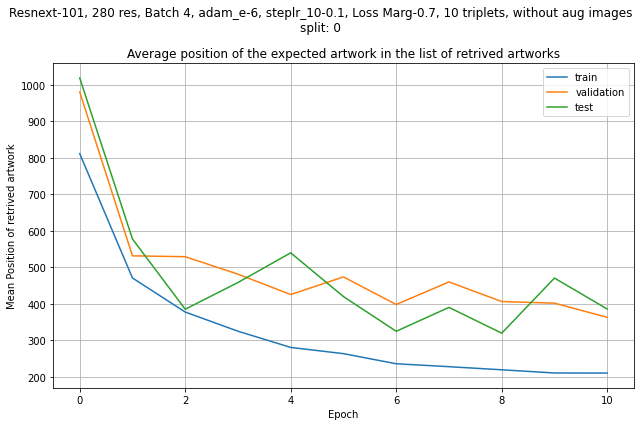

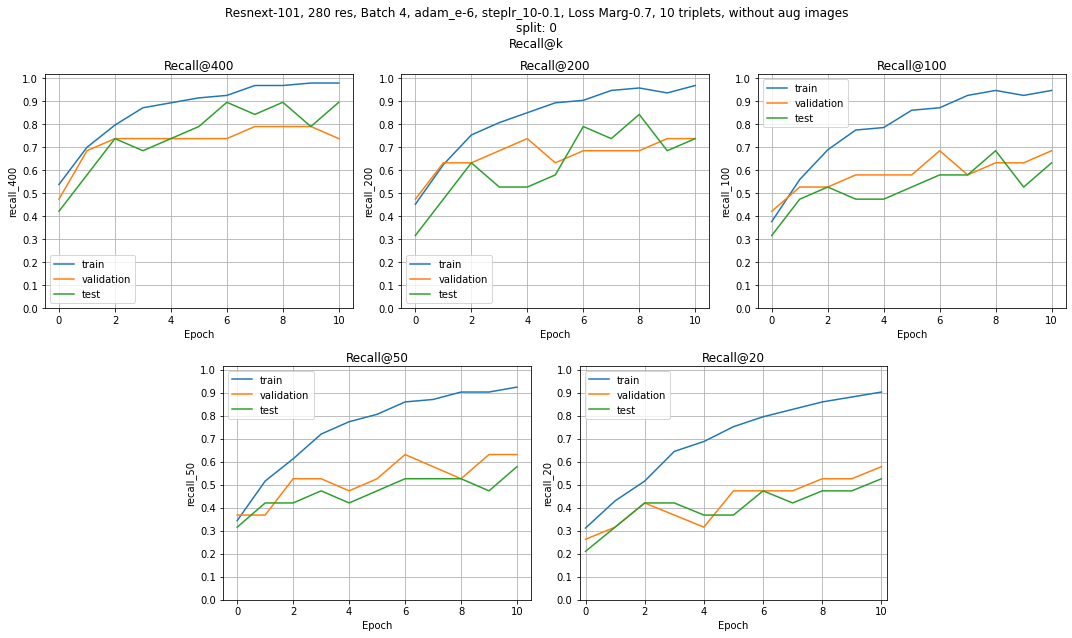

In [5]:
split_id = 0

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [6]:
best_epoch = 10

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v1

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,788.702381,1124.625000,765.087500,0.241210,0.550000,0.437500,0.425000,0.387500,0.350000
1,476.476190,535.175000,469.100000,0.318184,0.725000,0.650000,0.587500,0.537500,0.462500
2,372.994048,338.362500,367.831250,0.374072,0.812500,0.737500,0.662500,0.587500,0.525000
3,323.309524,233.500000,313.325000,0.417555,0.837500,0.775000,0.737500,0.650000,0.562500
4,288.375000,122.562500,253.093750,0.488690,0.900000,0.812500,0.812500,0.762500,0.687500
5,268.494048,128.137500,254.681250,0.540270,0.912500,0.850000,0.837500,0.800000,0.775000
6,246.630952,63.025000,222.300000,0.594386,0.950000,0.912500,0.862500,0.812500,0.775000
7,224.595238,65.450000,218.925000,0.645041,0.975000,0.950000,0.900000,0.850000,0.800000
8,219.250000,33.525000,207.900000,0.686691,0.975000,0.950000,0.887500,0.875000,0.812500
9,212.375000,16.312500,198.231250,0.762376,0.975000,0.975000,0.950000,0.925000,0.875000


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,872.733333,1345.466667,872.733333,0.105185,0.400000,0.400000,0.300000,0.266667,0.200000
1,588.283333,776.566667,588.283333,0.132324,0.566667,0.500000,0.433333,0.366667,0.300000
2,457.383333,514.766667,457.383333,0.141228,0.600000,0.533333,0.433333,0.400000,0.300000
3,435.950000,471.900000,435.950000,0.156945,0.666667,0.466667,0.466667,0.433333,0.300000
4,461.033333,522.066667,461.033333,0.136997,0.633333,0.500000,0.466667,0.400000,0.333333
5,312.566667,225.133333,312.566667,0.178669,0.800000,0.600000,0.533333,0.466667,0.333333
6,346.683333,293.366667,346.683333,0.191396,0.733333,0.600000,0.566667,0.500000,0.333333
7,353.150000,306.300000,353.150000,0.208141,0.700000,0.633333,0.566667,0.400000,0.366667
8,322.150000,244.300000,322.150000,0.216826,0.766667,0.633333,0.500000,0.500000,0.400000
9,300.050000,200.100000,300.050000,0.166797,0.866667,0.733333,0.633333,0.433333,0.366667


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1170.238095,1940.476190,1170.238095,0.112632,0.523810,0.476190,0.285714,0.285714,0.190476
1,575.952381,751.904762,575.952381,0.217338,0.714286,0.571429,0.523810,0.476190,0.380952
2,508.928571,617.857143,508.928571,0.260081,0.809524,0.761905,0.666667,0.571429,0.476190
3,502.523810,605.047619,502.523810,0.303278,0.809524,0.761905,0.523810,0.523810,0.380952
4,529.904762,659.809524,529.904762,0.299325,0.761905,0.714286,0.666667,0.571429,0.428571
5,488.333333,576.666667,488.333333,0.351939,0.761905,0.666667,0.666667,0.619048,0.428571
6,441.642857,483.285714,441.642857,0.359348,0.761905,0.666667,0.619048,0.523810,0.428571
7,404.666667,409.333333,404.666667,0.303807,0.809524,0.714286,0.571429,0.476190,0.428571
8,422.428571,444.857143,422.428571,0.331513,0.809524,0.666667,0.571429,0.476190,0.380952
9,428.976190,457.952381,428.976190,0.361160,0.809524,0.809524,0.619048,0.571429,0.428571


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,995.235294,1590.470588,995.235294,0.108251,0.450980,0.431373,0.294118,0.274510,0.196078
1,583.205882,766.411765,583.205882,0.167329,0.627451,0.529412,0.470588,0.411765,0.333333
2,478.607843,557.215686,478.607843,0.190168,0.686275,0.627451,0.529412,0.470588,0.372549
3,463.362745,526.725490,463.362745,0.217200,0.725490,0.588235,0.490196,0.470588,0.333333
4,489.392157,578.784314,489.392157,0.203838,0.686275,0.588235,0.549020,0.470588,0.372549
5,384.941176,369.882353,384.941176,0.250016,0.784314,0.627451,0.588235,0.529412,0.372549
6,385.784314,371.568627,385.784314,0.260553,0.745098,0.627451,0.588235,0.509804,0.372549
7,374.362745,348.725490,374.362745,0.247533,0.745098,0.666667,0.568627,0.431373,0.392157
8,363.441176,326.882353,363.441176,0.264050,0.784314,0.647059,0.529412,0.490196,0.392157
9,353.137255,306.274510,353.137255,0.246829,0.843137,0.764706,0.627451,0.490196,0.392157


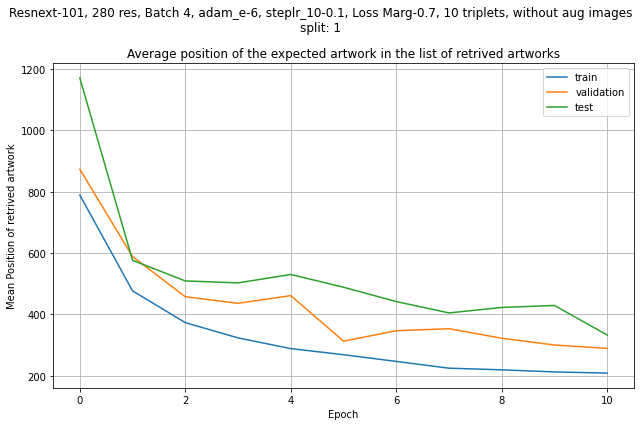

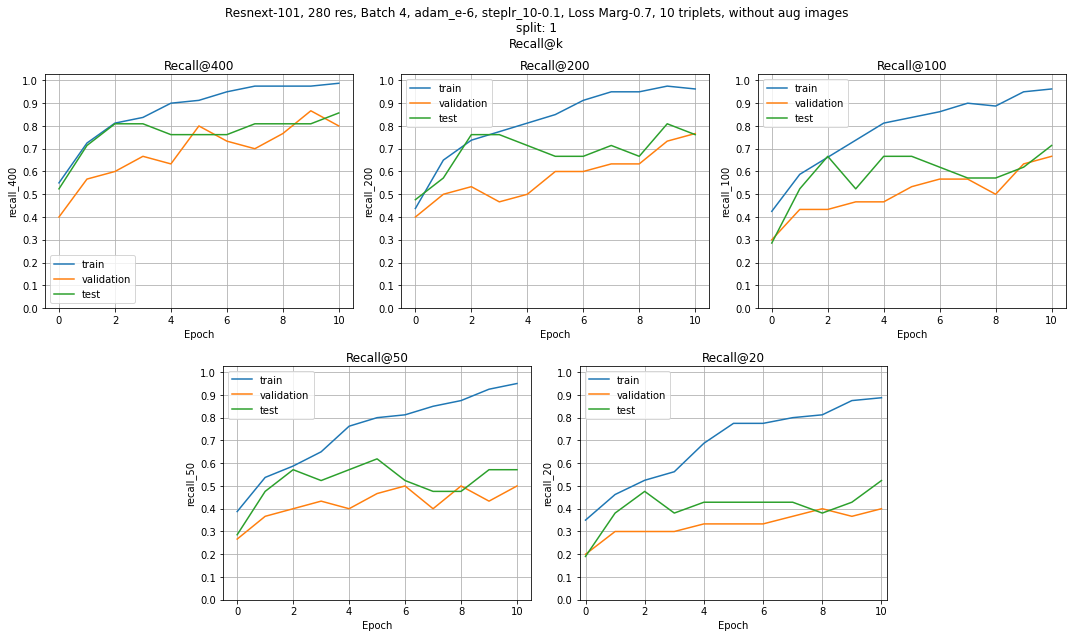

In [7]:
split_id = 1

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [8]:
best_epoch = 10

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v2

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,771.376471,1086.609756,741.634146,0.242444,0.573171,0.512195,0.439024,0.414634,0.365854
1,482.364706,536.975610,467.939024,0.310835,0.719512,0.670732,0.597561,0.560976,0.475610
2,374.564706,322.341463,357.731707,0.371139,0.829268,0.780488,0.719512,0.634146,0.573171
3,330.335294,241.646341,316.871951,0.459729,0.853659,0.817073,0.768293,0.695122,0.621951
4,283.617647,157.695122,274.189024,0.523167,0.890244,0.841463,0.829268,0.804878,0.731707
5,281.205882,160.182927,275.262195,0.603899,0.878049,0.853659,0.853659,0.829268,0.780488
6,250.847059,88.268293,239.304878,0.669645,0.939024,0.902439,0.878049,0.865854,0.841463
7,236.682353,81.048780,235.524390,0.679598,0.939024,0.926829,0.890244,0.878049,0.829268
8,226.458824,60.731707,224.487805,0.754429,0.975610,0.939024,0.902439,0.865854,0.853659
9,210.111765,18.329268,204.335366,0.813880,0.975610,0.963415,0.939024,0.926829,0.878049


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1142.863636,1885.727273,1142.863636,0.093328,0.409091,0.227273,0.181818,0.090909,0.090909
1,620.886364,841.772727,620.886364,0.136837,0.636364,0.500000,0.409091,0.272727,0.227273
2,491.568182,583.136364,491.568182,0.170977,0.681818,0.454545,0.363636,0.363636,0.227273
3,489.863636,579.727273,489.863636,0.203154,0.636364,0.590909,0.454545,0.318182,0.318182
4,433.954545,467.909091,433.954545,0.244876,0.681818,0.636364,0.500000,0.409091,0.318182
5,422.113636,444.227273,422.113636,0.223802,0.681818,0.590909,0.454545,0.409091,0.363636
6,411.659091,423.318182,411.659091,0.250818,0.772727,0.636364,0.500000,0.409091,0.363636
7,417.681818,435.363636,417.681818,0.265591,0.727273,0.636364,0.590909,0.500000,0.454545
8,391.772727,383.545455,391.772727,0.251389,0.772727,0.681818,0.590909,0.454545,0.409091
9,353.204545,306.409091,353.204545,0.315860,0.772727,0.681818,0.681818,0.500000,0.363636


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,939.214286,1499.851852,963.222222,0.106815,0.407407,0.370370,0.333333,0.333333,0.222222
1,839.482143,1313.000000,860.018519,0.130552,0.481481,0.370370,0.370370,0.370370,0.296296
2,611.500000,847.925926,625.851852,0.158230,0.518519,0.407407,0.370370,0.333333,0.333333
3,541.071429,691.629630,556.333333,0.135723,0.555556,0.444444,0.333333,0.333333,0.333333
4,492.053571,608.037037,497.944444,0.159261,0.629630,0.555556,0.370370,0.296296,0.259259
5,390.017857,392.037037,395.425926,0.164333,0.666667,0.592593,0.444444,0.333333,0.296296
6,396.107143,411.851852,400.000000,0.140549,0.740741,0.629630,0.444444,0.370370,0.296296
7,460.053571,535.296296,469.277778,0.186252,0.629630,0.481481,0.407407,0.370370,0.333333
8,459.982143,536.777778,468.425926,0.180106,0.592593,0.481481,0.444444,0.296296,0.296296
9,386.482143,398.555556,386.907407,0.183128,0.740741,0.666667,0.444444,0.370370,0.333333


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1028.820000,1673.102041,1043.877551,0.100760,0.408163,0.306122,0.265306,0.224490,0.163265
1,743.300000,1101.428571,752.653061,0.133374,0.551020,0.428571,0.387755,0.326531,0.265306
2,558.730000,729.040816,565.561224,0.163953,0.591837,0.428571,0.367347,0.346939,0.285714
3,518.540000,641.387755,526.489796,0.165998,0.591837,0.510204,0.387755,0.326531,0.326531
4,466.490000,545.122449,469.214286,0.197700,0.653061,0.591837,0.428571,0.346939,0.285714
5,404.140000,415.469388,407.408163,0.191033,0.673469,0.591837,0.448980,0.367347,0.326531
6,402.950000,417.000000,405.234694,0.190058,0.755102,0.632653,0.469388,0.387755,0.326531
7,441.410000,490.428571,446.112245,0.221873,0.673469,0.551020,0.489796,0.428571,0.387755
8,429.970000,467.979592,434.010204,0.212111,0.673469,0.571429,0.510204,0.367347,0.346939
9,371.840000,357.183673,371.775510,0.242722,0.755102,0.673469,0.551020,0.428571,0.346939


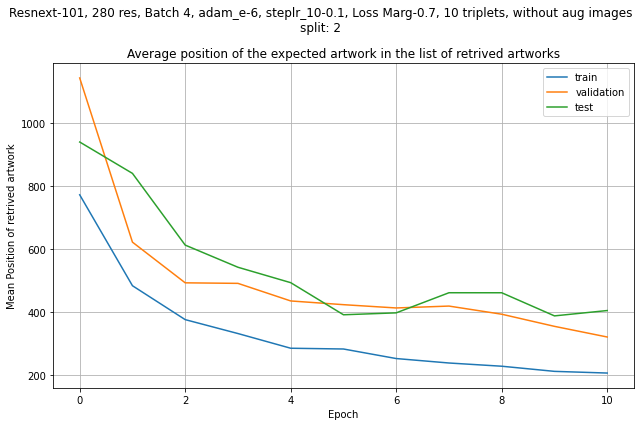

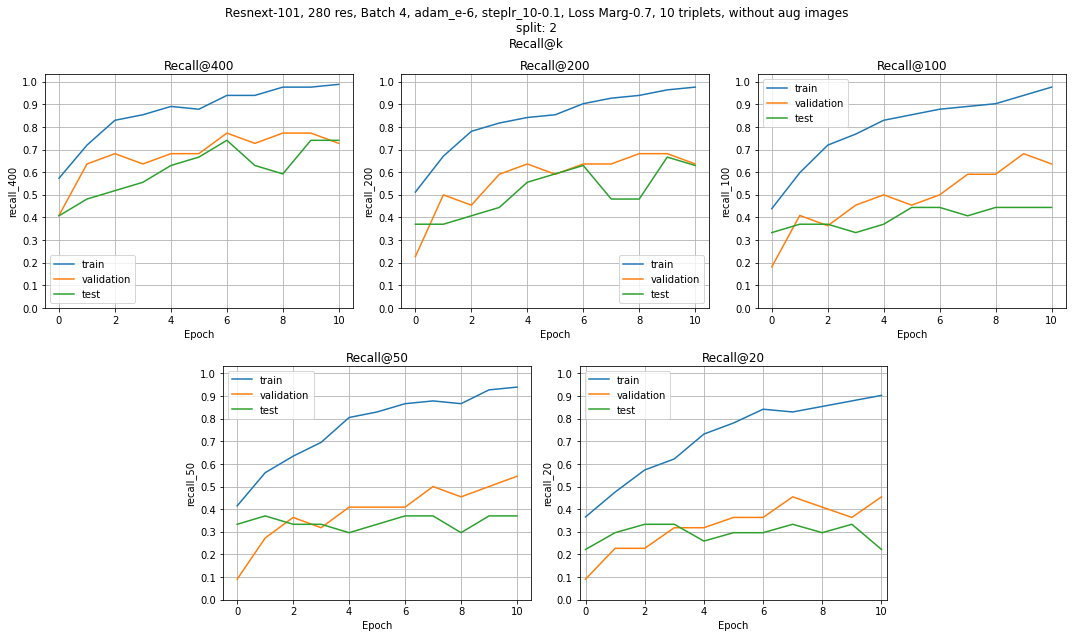

In [9]:
split_id = 2

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [10]:
best_epoch = 10

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v3

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,837.121795,1265.285714,833.487013,0.224970,0.571429,0.493506,0.402597,0.389610,0.363636
1,386.519231,382.454545,386.512987,0.346832,0.753247,0.662338,0.649351,0.636364,0.519481
2,312.634615,231.805195,312.188312,0.375728,0.831169,0.740260,0.701299,0.649351,0.597403
3,300.397436,208.467532,299.129870,0.440585,0.883117,0.818182,0.779221,0.740260,0.675325
4,238.089744,82.285714,236.012987,0.518565,0.961039,0.909091,0.844156,0.805195,0.766234
5,233.570513,73.181818,231.422078,0.598993,0.974026,0.922078,0.870130,0.831169,0.818182
6,214.570513,34.688312,212.175325,0.692174,0.974026,0.961039,0.922078,0.909091,0.896104
7,210.865385,27.181818,208.422078,0.737713,0.987013,0.974026,0.948052,0.922078,0.870130
8,202.211538,9.649351,199.655844,0.781685,1.000000,0.987013,0.961039,0.948052,0.896104
9,201.192308,7.584416,198.623377,0.845169,1.000000,0.987013,0.987013,0.948052,0.909091


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,936.666667,1532.758621,957.758621,0.160458,0.379310,0.344828,0.310345,0.241379,0.206897
1,598.683333,826.310345,611.431034,0.105924,0.551724,0.517241,0.344828,0.275862,0.275862
2,693.733333,1020.482759,711.206897,0.109219,0.517241,0.448276,0.344828,0.241379,0.206897
3,536.616667,700.586207,546.155172,0.123878,0.724138,0.689655,0.413793,0.310345,0.241379
4,490.266667,603.724138,498.689655,0.129492,0.620690,0.517241,0.379310,0.344828,0.275862
5,505.800000,636.896552,514.241379,0.153134,0.689655,0.517241,0.448276,0.379310,0.241379
6,365.216667,347.413793,367.879310,0.121670,0.758621,0.689655,0.482759,0.379310,0.310345
7,396.783333,414.931034,399.637931,0.158839,0.793103,0.724138,0.620690,0.448276,0.344828
8,361.666667,343.241379,362.827586,0.140857,0.724138,0.655172,0.655172,0.482759,0.344828
9,356.600000,334.827586,356.482759,0.165586,0.758621,0.655172,0.517241,0.448276,0.275862


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,874.537037,1168.280000,800.420000,0.113667,0.480000,0.360000,0.360000,0.320000,0.160000
1,589.500000,541.320000,492.980000,0.174306,0.720000,0.560000,0.440000,0.360000,0.240000
2,767.481481,970.000000,706.240000,0.158509,0.640000,0.520000,0.440000,0.360000,0.280000
3,517.018519,567.320000,495.620000,0.222770,0.680000,0.520000,0.520000,0.400000,0.400000
4,716.537037,784.360000,604.460000,0.232399,0.600000,0.560000,0.440000,0.400000,0.360000
5,662.203704,724.840000,583.540000,0.218704,0.680000,0.560000,0.480000,0.440000,0.360000
6,652.722222,534.440000,494.740000,0.211594,0.680000,0.600000,0.600000,0.520000,0.320000
7,595.740741,509.280000,485.160000,0.240318,0.720000,0.640000,0.520000,0.520000,0.400000
8,665.314815,571.080000,510.380000,0.198822,0.680000,0.560000,0.480000,0.440000,0.440000
9,689.148148,616.560000,530.880000,0.223627,0.680000,0.640000,0.560000,0.440000,0.400000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,907.236842,1364.018519,884.916667,0.138795,0.425926,0.351852,0.333333,0.277778,0.185185
1,594.333333,694.370370,556.592593,0.137582,0.629630,0.537037,0.388889,0.314815,0.259259
2,728.666667,997.111111,708.907407,0.132039,0.574074,0.481481,0.388889,0.296296,0.240741
3,527.333333,638.888889,522.759259,0.169661,0.703704,0.611111,0.462963,0.351852,0.314815
4,597.447368,687.351852,547.657407,0.177134,0.611111,0.537037,0.407407,0.370370,0.314815
5,579.885965,677.611111,546.324074,0.183490,0.685185,0.537037,0.462963,0.407407,0.296296
6,501.403509,434.000000,426.611111,0.163301,0.722222,0.648148,0.537037,0.444444,0.314815
7,491.026316,458.611111,439.231481,0.196561,0.759259,0.685185,0.574074,0.481481,0.370370
8,505.500000,448.722222,431.138889,0.167692,0.703704,0.611111,0.574074,0.462963,0.388889
9,514.122807,465.259259,437.222222,0.192457,0.722222,0.648148,0.537037,0.444444,0.333333


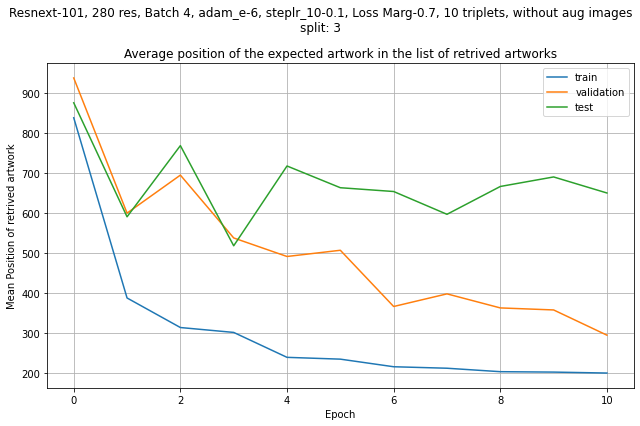

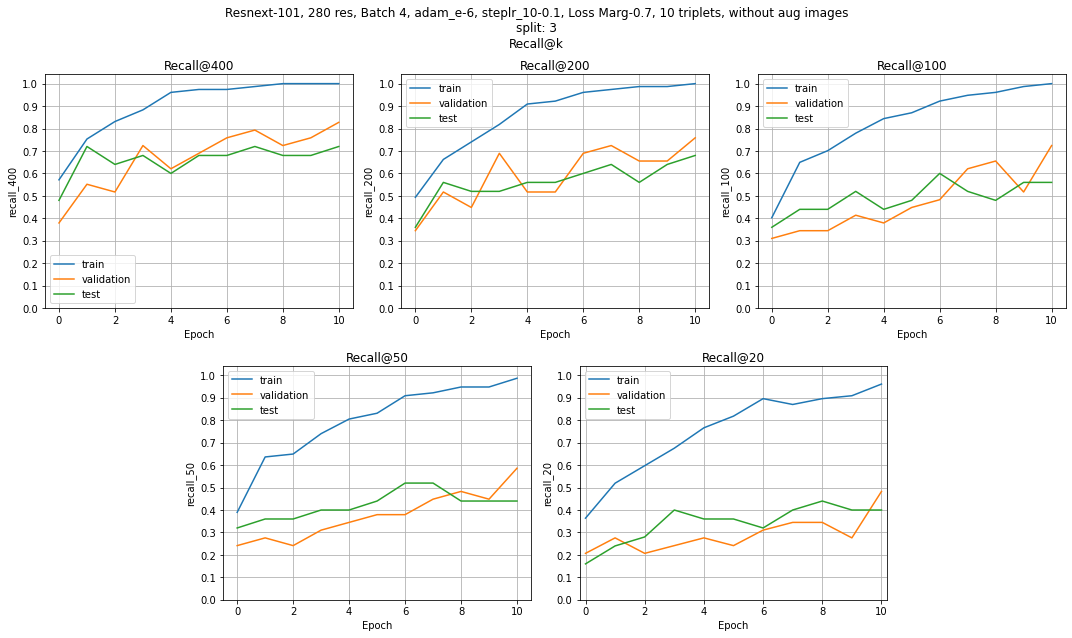

In [11]:
split_id = 3

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [12]:
best_epoch = 10

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v4

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,788.253012,1103.308642,753.049383,0.198104,0.567901,0.493827,0.419753,0.395062,0.320988
1,402.192771,380.419753,390.246914,0.309930,0.777778,0.679012,0.654321,0.617284,0.506173
2,322.253012,234.839506,317.444444,0.388060,0.839506,0.790123,0.716049,0.654321,0.604938
3,276.192771,136.493827,268.271605,0.451568,0.876543,0.839506,0.814815,0.753086,0.691358
4,244.174699,79.666667,239.858025,0.532577,0.913580,0.864198,0.827160,0.802469,0.740741
5,235.216867,65.012346,232.543210,0.571442,0.950617,0.913580,0.876543,0.851852,0.777778
6,218.493976,28.543210,214.296296,0.637122,0.975309,0.925926,0.901235,0.876543,0.839506
7,218.271084,13.839506,206.944444,0.684294,0.987654,0.975309,0.950617,0.901235,0.864198
8,208.349398,10.222222,205.135802,0.753674,0.987654,0.975309,0.950617,0.913580,0.901235
9,205.277108,5.407407,202.728395,0.790831,0.987654,0.987654,0.975309,0.950617,0.913580


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,870.725806,1356.166667,890.050000,0.129966,0.433333,0.333333,0.266667,0.233333,0.200000
1,491.725806,579.966667,499.150000,0.172689,0.566667,0.433333,0.300000,0.233333,0.233333
2,438.225806,482.600000,447.066667,0.147721,0.633333,0.500000,0.366667,0.266667,0.266667
3,384.032258,382.466667,388.033333,0.163488,0.700000,0.533333,0.433333,0.366667,0.233333
4,336.145161,273.100000,341.450000,0.212158,0.800000,0.566667,0.433333,0.333333,0.300000
5,334.145161,266.366667,342.050000,0.148342,0.800000,0.633333,0.500000,0.400000,0.266667
6,338.919355,282.366667,342.250000,0.181733,0.800000,0.566667,0.433333,0.400000,0.233333
7,300.919355,211.033333,301.850000,0.189652,0.900000,0.666667,0.600000,0.400000,0.333333
8,319.838710,252.533333,320.566667,0.188578,0.800000,0.700000,0.566667,0.533333,0.333333
9,324.354839,259.133333,326.866667,0.194296,0.866667,0.700000,0.600000,0.433333,0.300000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1170.976190,2051.550000,1213.275000,0.243612,0.400000,0.350000,0.350000,0.300000,0.300000
1,770.642857,1195.450000,800.075000,0.219655,0.650000,0.500000,0.500000,0.450000,0.400000
2,652.666667,929.600000,684.600000,0.230160,0.600000,0.550000,0.500000,0.500000,0.450000
3,621.285714,894.000000,637.500000,0.252608,0.700000,0.650000,0.500000,0.500000,0.450000
4,583.119048,812.450000,598.325000,0.275981,0.700000,0.600000,0.550000,0.500000,0.450000
5,611.738095,870.050000,629.575000,0.237196,0.700000,0.650000,0.550000,0.500000,0.400000
6,513.047619,669.100000,522.800000,0.270648,0.700000,0.700000,0.650000,0.550000,0.400000
7,430.785714,502.350000,433.425000,0.322185,0.700000,0.700000,0.600000,0.550000,0.450000
8,458.214286,551.350000,466.575000,0.332378,0.700000,0.650000,0.600000,0.550000,0.450000
9,468.952381,579.800000,474.900000,0.344730,0.700000,0.700000,0.650000,0.550000,0.450000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,991.980769,1634.320000,1019.340000,0.175424,0.420000,0.340000,0.300000,0.260000,0.240000
1,604.365385,826.160000,619.520000,0.191475,0.600000,0.460000,0.380000,0.320000,0.300000
2,524.826923,661.400000,542.080000,0.180697,0.620000,0.520000,0.420000,0.360000,0.340000
3,479.846154,587.080000,487.820000,0.199136,0.700000,0.580000,0.460000,0.420000,0.320000
4,435.884615,488.840000,444.200000,0.237687,0.760000,0.580000,0.480000,0.400000,0.360000
5,446.250000,507.840000,457.060000,0.183883,0.760000,0.640000,0.520000,0.440000,0.320000
6,409.240385,437.060000,414.470000,0.217299,0.760000,0.620000,0.520000,0.460000,0.300000
7,353.365385,327.560000,354.480000,0.242665,0.820000,0.680000,0.600000,0.460000,0.380000
8,375.721154,372.060000,378.970000,0.246098,0.760000,0.680000,0.580000,0.540000,0.380000
9,382.750000,387.400000,386.080000,0.254470,0.800000,0.700000,0.620000,0.480000,0.360000


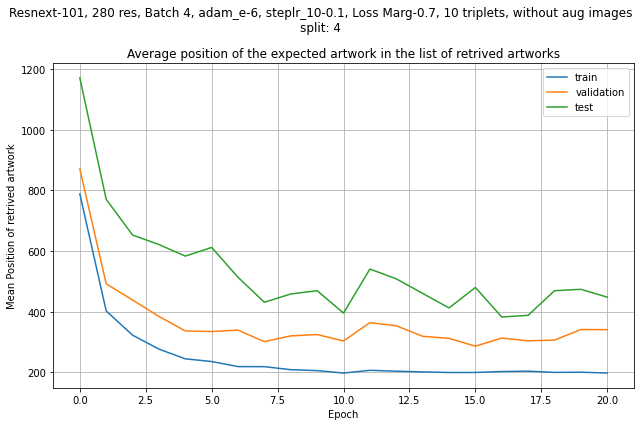

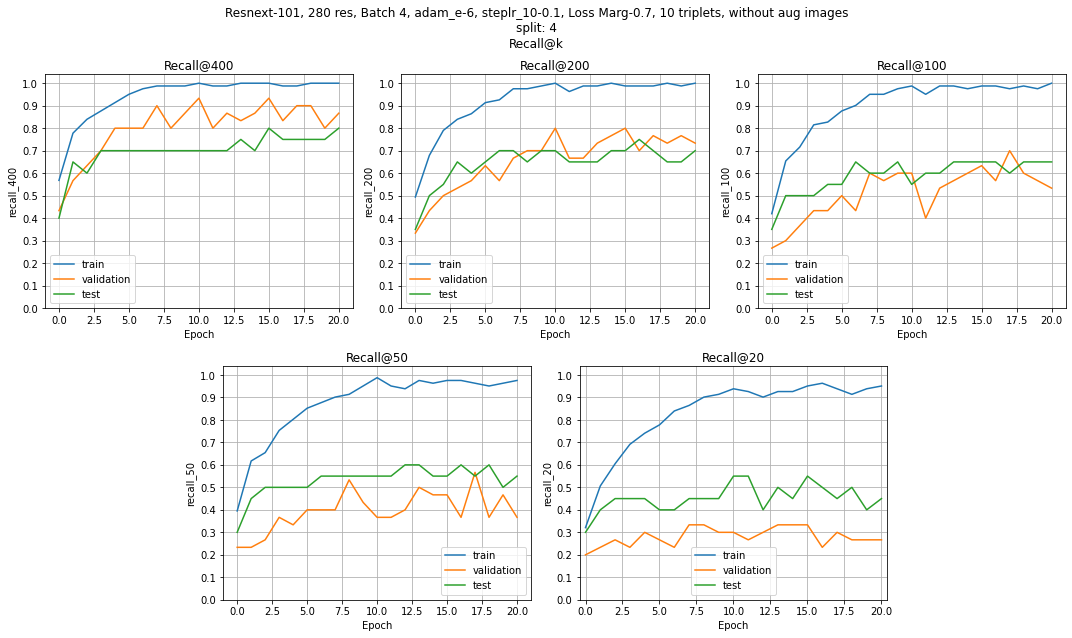

In [13]:
split_id = 4

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [14]:
best_epoch = 15

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v5

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,792.011628,1130.048193,763.373494,0.199198,0.578313,0.481928,0.409639,0.361446,0.325301
1,469.325581,545.566265,473.783133,0.284546,0.734940,0.662651,0.626506,0.542169,0.457831
2,391.011628,349.927711,374.734940,0.310645,0.807229,0.734940,0.698795,0.638554,0.542169
3,318.610465,220.469880,306.295181,0.435652,0.879518,0.795181,0.771084,0.759036,0.674699
4,312.529070,206.903614,299.379518,0.470882,0.867470,0.843373,0.795181,0.734940,0.662651
5,294.168605,172.445783,281.680723,0.524336,0.879518,0.819277,0.807229,0.771084,0.710843
6,253.505814,78.036145,234.234940,0.566161,0.915663,0.879518,0.831325,0.807229,0.771084
7,258.250000,104.156627,247.331325,0.647315,0.939759,0.915663,0.867470,0.867470,0.807229
8,217.808140,21.674699,206.066265,0.742611,0.975904,0.975904,0.927711,0.891566,0.879518
9,214.970930,15.168675,202.813253,0.757505,0.987952,0.963855,0.951807,0.915663,0.867470


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1169.086207,1938.172414,1169.086207,0.142246,0.379310,0.344828,0.275862,0.275862,0.172414
1,716.775862,1033.551724,716.775862,0.194798,0.517241,0.344828,0.344828,0.310345,0.275862
2,731.293103,1062.586207,731.293103,0.174438,0.448276,0.344828,0.310345,0.310345,0.310345
3,473.775862,547.551724,473.775862,0.163298,0.586207,0.482759,0.448276,0.310345,0.275862
4,472.224138,544.448276,472.224138,0.200623,0.655172,0.448276,0.413793,0.310345,0.310345
5,387.120690,374.241379,387.120690,0.170462,0.724138,0.620690,0.482759,0.310345,0.310345
6,356.396552,312.793103,356.396552,0.210009,0.758621,0.655172,0.517241,0.310345,0.310345
7,345.655172,291.310345,345.655172,0.193693,0.758621,0.620690,0.517241,0.344828,0.310345
8,299.758621,199.517241,299.758621,0.243980,0.931034,0.758621,0.620690,0.517241,0.310345
9,323.137931,246.275862,323.137931,0.232535,0.896552,0.758621,0.620690,0.448276,0.310345


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,749.575000,1109.631579,773.710526,0.218896,0.421053,0.368421,0.368421,0.368421,0.315789
1,418.000000,457.052632,426.105263,0.283119,0.789474,0.684211,0.631579,0.473684,0.421053
2,435.925000,454.263158,440.552632,0.260542,0.684211,0.578947,0.473684,0.473684,0.473684
3,290.875000,196.789474,292.026316,0.322538,0.842105,0.789474,0.684211,0.578947,0.526316
4,329.500000,237.263158,333.842105,0.290970,0.789474,0.684211,0.631579,0.473684,0.421053
5,318.700000,239.157895,329.789474,0.292649,0.789474,0.684211,0.684211,0.631579,0.578947
6,317.725000,260.578947,317.342105,0.278613,0.842105,0.789474,0.789474,0.631579,0.421053
7,265.175000,142.263158,264.605263,0.220725,0.894737,0.894737,0.684211,0.684211,0.421053
8,223.550000,60.000000,219.000000,0.345501,0.947368,0.894737,0.736842,0.736842,0.684211
9,228.875000,73.736842,223.500000,0.363842,0.947368,0.842105,0.789474,0.736842,0.736842


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,997.857143,1610.208333,1012.583333,0.172587,0.395833,0.354167,0.312500,0.312500,0.229167
1,594.826531,805.354167,601.718750,0.229758,0.625000,0.479167,0.458333,0.375000,0.333333
2,610.734694,821.791667,616.208333,0.208521,0.541667,0.437500,0.375000,0.375000,0.375000
3,399.122449,408.708333,401.833333,0.226330,0.687500,0.604167,0.541667,0.416667,0.375000
4,413.969388,422.854167,417.447917,0.236385,0.708333,0.541667,0.500000,0.375000,0.354167
5,359.193878,320.770833,364.427083,0.218828,0.750000,0.645833,0.562500,0.437500,0.416667
6,340.612245,292.125000,340.937500,0.237165,0.791667,0.708333,0.625000,0.437500,0.354167
7,312.806122,232.312500,313.572917,0.204393,0.812500,0.729167,0.583333,0.479167,0.354167
8,268.653061,144.291667,267.791667,0.284166,0.937500,0.812500,0.666667,0.604167,0.458333
9,284.663265,177.979167,283.697917,0.284511,0.916667,0.791667,0.687500,0.562500,0.479167


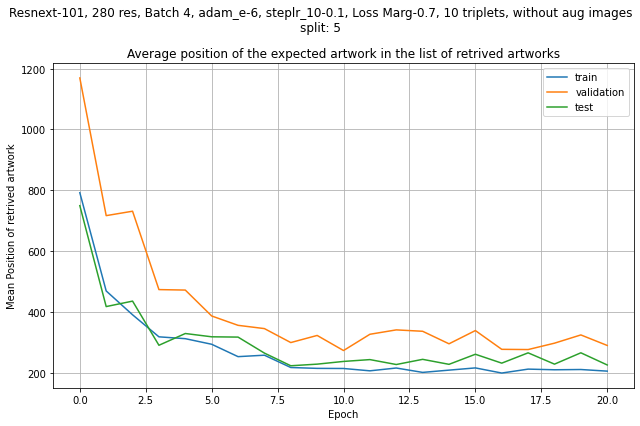

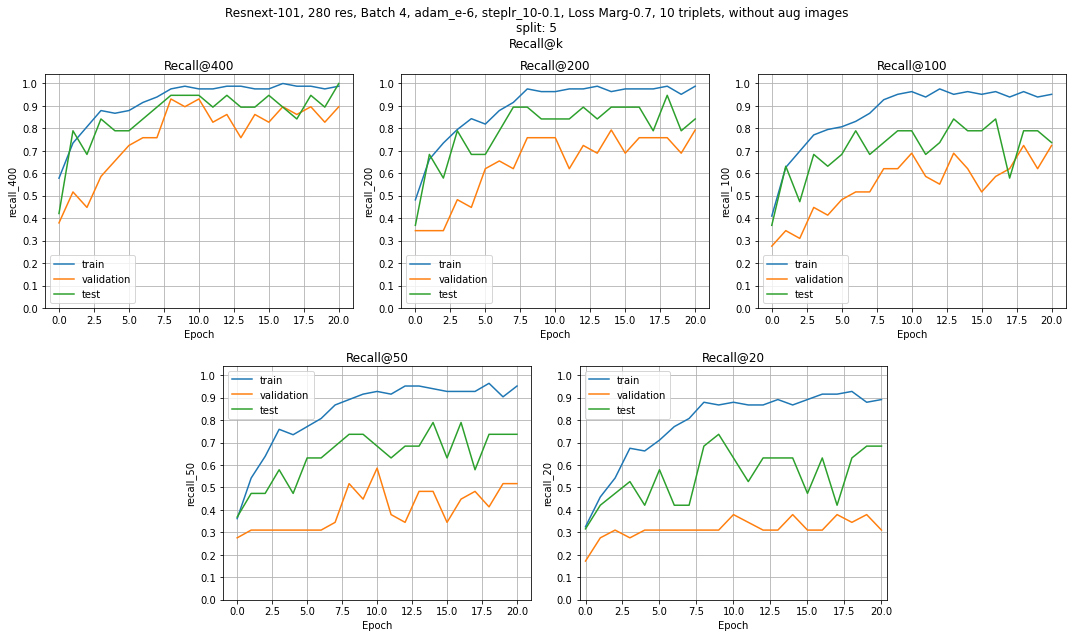

In [15]:
split_id = 5

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [16]:
best_epoch = 10

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v6

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,787.609756,1196.475000,799.600000,0.241216,0.575000,0.500000,0.437500,0.387500,0.325000
1,454.390244,517.250000,461.350000,0.273647,0.775000,0.700000,0.587500,0.512500,0.425000
2,355.878049,320.100000,358.537500,0.356244,0.812500,0.762500,0.687500,0.600000,0.525000
3,301.268293,210.775000,301.287500,0.423092,0.887500,0.837500,0.762500,0.675000,0.625000
4,282.414634,171.850000,280.437500,0.489551,0.887500,0.825000,0.812500,0.775000,0.687500
5,238.012195,86.525000,234.600000,0.542207,0.937500,0.912500,0.875000,0.850000,0.787500
6,237.268293,84.075000,234.262500,0.598072,0.962500,0.925000,0.912500,0.850000,0.825000
7,209.628049,28.087500,205.606250,0.717193,0.975000,0.937500,0.912500,0.887500,0.875000
8,207.036585,22.000000,203.000000,0.743743,0.987500,0.975000,0.937500,0.912500,0.862500
9,199.890244,9.600000,194.975000,0.822155,1.000000,0.987500,0.975000,0.937500,0.912500


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,814.425000,905.277778,658.916667,0.059158,0.444444,0.333333,0.277778,0.277778,0.222222
1,551.525000,497.388889,448.361111,0.129419,0.722222,0.611111,0.500000,0.500000,0.277778
2,553.000000,486.111111,452.444444,0.142670,0.666667,0.666667,0.500000,0.388889,0.277778
3,537.000000,364.555556,388.333333,0.146751,0.722222,0.666667,0.611111,0.500000,0.277778
4,477.850000,319.555556,368.944444,0.201038,0.777778,0.666667,0.500000,0.444444,0.333333
5,491.150000,274.777778,338.777778,0.153683,0.722222,0.722222,0.722222,0.611111,0.444444
6,535.400000,246.888889,323.277778,0.171710,0.777778,0.722222,0.666667,0.611111,0.444444
7,424.600000,230.111111,318.944444,0.258511,0.833333,0.722222,0.722222,0.555556,0.444444
8,435.800000,200.555556,303.166667,0.230893,0.833333,0.777778,0.722222,0.666667,0.444444
9,422.300000,151.777778,280.944444,0.289710,0.833333,0.722222,0.666667,0.611111,0.444444


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1095.015152,1790.030303,1095.015152,0.135016,0.393939,0.333333,0.272727,0.272727,0.242424
1,759.181818,1118.363636,759.181818,0.210058,0.484848,0.363636,0.363636,0.303030,0.303030
2,633.590909,867.181818,633.590909,0.218706,0.484848,0.363636,0.333333,0.333333,0.333333
3,554.772727,709.545455,554.772727,0.204424,0.515152,0.515152,0.454545,0.303030,0.303030
4,552.333333,704.666667,552.333333,0.186203,0.666667,0.454545,0.454545,0.363636,0.303030
5,539.575758,679.151515,539.575758,0.235944,0.515152,0.454545,0.333333,0.333333,0.272727
6,521.848485,643.696970,521.848485,0.203672,0.545455,0.454545,0.393939,0.333333,0.303030
7,432.090909,464.181818,432.090909,0.204121,0.696970,0.545455,0.545455,0.393939,0.333333
8,413.454545,426.909091,413.454545,0.213321,0.757576,0.545455,0.515152,0.363636,0.333333
9,444.242424,488.484848,444.242424,0.221518,0.636364,0.545455,0.515152,0.393939,0.272727


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,989.132075,1477.764706,941.098039,0.108242,0.411765,0.333333,0.274510,0.274510,0.235294
1,680.820755,899.196078,649.480392,0.181597,0.568627,0.450980,0.411765,0.372549,0.294118
2,603.179245,732.686275,569.656863,0.191870,0.549020,0.470588,0.392157,0.352941,0.313725
3,548.066038,587.784314,496.029412,0.184069,0.588235,0.568627,0.509804,0.372549,0.294118
4,524.226415,568.745098,487.607843,0.191439,0.705882,0.529412,0.470588,0.392157,0.313725
5,521.301887,536.431373,468.705882,0.206911,0.588235,0.549020,0.470588,0.431373,0.333333
6,526.962264,503.647059,451.764706,0.192392,0.627451,0.549020,0.490196,0.431373,0.352941
7,429.264151,381.568627,392.156863,0.223318,0.745098,0.607843,0.607843,0.450980,0.372549
8,421.886792,347.019608,374.529412,0.219523,0.784314,0.627451,0.588235,0.470588,0.372549
9,435.962264,369.647059,386.607843,0.245586,0.705882,0.607843,0.568627,0.470588,0.333333


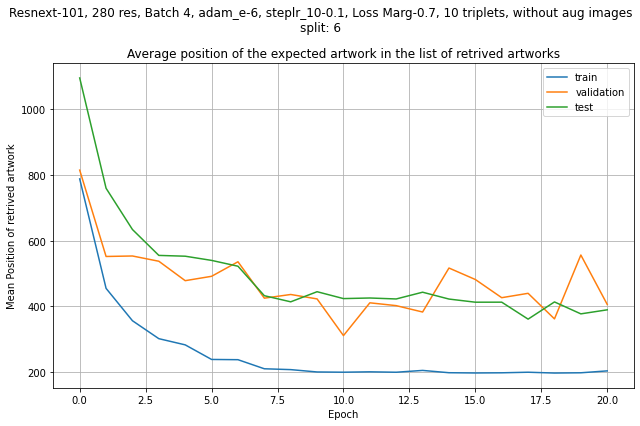

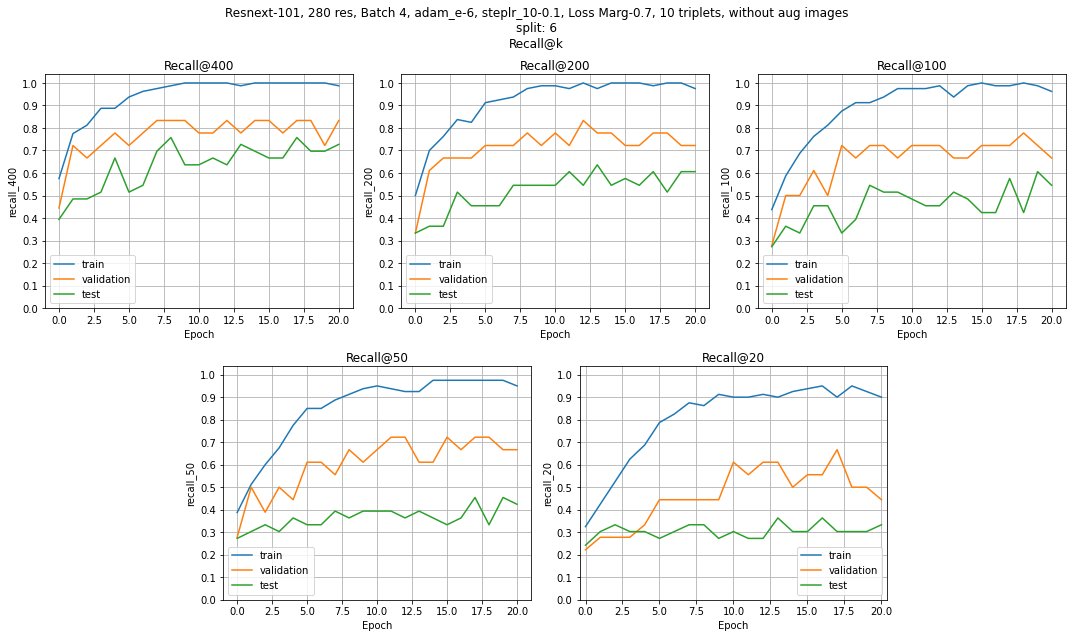

In [17]:
split_id = 6

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [18]:
best_epoch = 10

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v7

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,761.836842,1140.849462,771.596774,0.205814,0.548387,0.451613,0.408602,0.376344,0.344086
1,378.052632,365.806452,380.505376,0.320529,0.784946,0.698925,0.634409,0.548387,0.473118
2,299.094737,206.236559,299.139785,0.361599,0.870968,0.784946,0.731183,0.698925,0.612903
3,256.631579,122.236559,254.408602,0.468502,0.903226,0.870968,0.795699,0.709677,0.666667
4,221.378947,49.935484,218.591398,0.561345,0.956989,0.924731,0.881720,0.838710,0.731183
5,216.963158,42.956989,213.155914,0.654497,0.956989,0.913978,0.892473,0.860215,0.849462
6,210.078947,28.677419,206.166667,0.686583,0.967742,0.946237,0.913978,0.892473,0.870968
7,204.210526,17.010753,200.096774,0.740665,1.000000,0.978495,0.946237,0.913978,0.881720
8,201.384211,11.086022,197.284946,0.807583,1.000000,0.989247,0.978495,0.913978,0.892473
9,199.994737,8.075269,195.951613,0.795085,1.000000,0.989247,0.978495,0.956989,0.903226


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1372.710526,2345.421053,1372.710526,0.084416,0.368421,0.368421,0.263158,0.263158,0.105263
1,874.157895,1348.315789,874.157895,0.185137,0.578947,0.473684,0.421053,0.263158,0.263158
2,831.947368,1263.894737,831.947368,0.198267,0.578947,0.526316,0.473684,0.368421,0.263158
3,776.026316,1152.052632,776.026316,0.203291,0.684211,0.631579,0.421053,0.368421,0.315789
4,673.236842,946.473684,673.236842,0.196884,0.631579,0.578947,0.526316,0.421053,0.315789
5,669.000000,938.000000,669.000000,0.239713,0.684211,0.631579,0.473684,0.421053,0.368421
6,559.947368,719.894737,559.947368,0.221589,0.631579,0.631579,0.526316,0.473684,0.368421
7,698.157895,996.315789,698.157895,0.175706,0.684211,0.578947,0.526316,0.368421,0.368421
8,596.026316,792.052632,596.026316,0.289634,0.684211,0.631579,0.526316,0.473684,0.368421
9,545.657895,691.315789,545.657895,0.335852,0.684211,0.631579,0.473684,0.368421,0.368421


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,883.428571,1074.842105,743.368421,0.214369,0.473684,0.421053,0.315789,0.263158,0.210526
1,580.595238,503.000000,462.236842,0.208120,0.684211,0.631579,0.526316,0.526316,0.368421
2,661.095238,556.947368,480.894737,0.237362,0.684211,0.631579,0.578947,0.578947,0.368421
3,585.404762,456.263158,434.973684,0.249244,0.684211,0.684211,0.631579,0.473684,0.421053
4,579.761905,484.526316,443.263158,0.305669,0.684211,0.631579,0.631579,0.578947,0.526316
5,554.690476,380.157895,391.131579,0.289364,0.736842,0.684211,0.684211,0.631579,0.526316
6,696.547619,395.631579,398.973684,0.293620,0.736842,0.736842,0.684211,0.578947,0.473684
7,564.833333,375.210526,388.815789,0.353689,0.789474,0.736842,0.736842,0.631579,0.526316
8,549.476190,321.578947,361.157895,0.334153,0.789474,0.736842,0.684211,0.684211,0.526316
9,611.833333,311.736842,358.552632,0.353678,0.789474,0.736842,0.684211,0.684211,0.526316


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1115.837500,1710.131579,1058.039474,0.149393,0.421053,0.394737,0.289474,0.263158,0.157895
1,720.037500,925.657895,668.197368,0.196629,0.631579,0.552632,0.473684,0.394737,0.315789
2,742.250000,910.421053,656.421053,0.217815,0.631579,0.578947,0.526316,0.473684,0.315789
3,675.950000,804.157895,605.500000,0.226268,0.684211,0.657895,0.526316,0.421053,0.368421
4,624.162500,715.500000,558.250000,0.251276,0.657895,0.605263,0.578947,0.500000,0.421053
5,608.987500,659.078947,530.065789,0.264538,0.710526,0.657895,0.578947,0.526316,0.447368
6,631.662500,557.763158,479.460526,0.257604,0.684211,0.684211,0.605263,0.526316,0.421053
7,628.162500,685.763158,543.486842,0.264697,0.736842,0.657895,0.631579,0.500000,0.447368
8,571.587500,556.815789,478.592105,0.311893,0.736842,0.684211,0.605263,0.578947,0.447368
9,580.400000,501.526316,452.105263,0.344765,0.736842,0.684211,0.578947,0.526316,0.447368


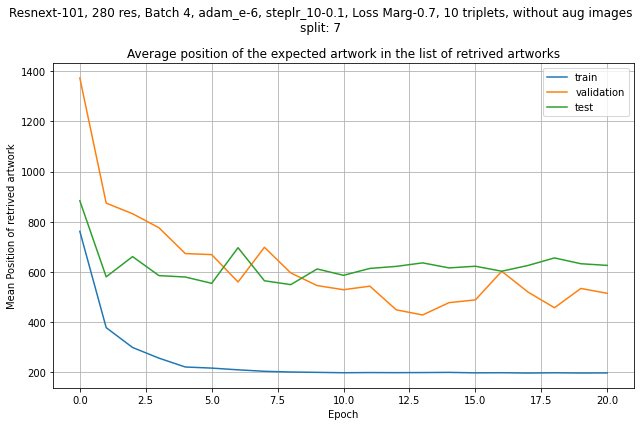

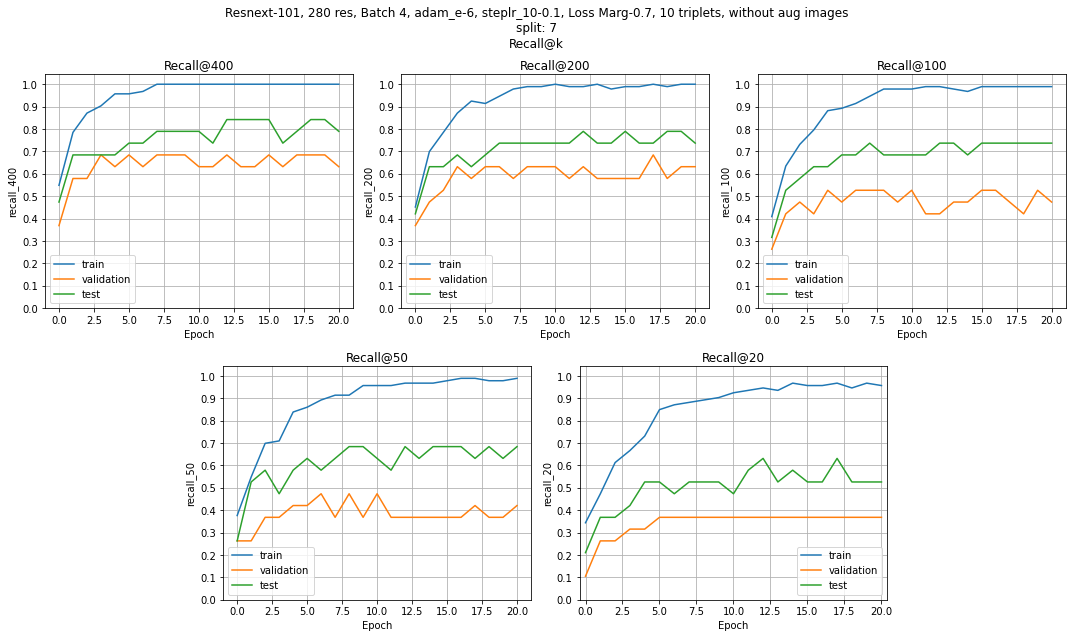

In [19]:
split_id = 7

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [20]:
best_epoch = 12

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v8

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,707.023256,1019.204819,711.698795,0.216019,0.554217,0.493976,0.445783,0.397590,0.337349
1,437.744186,490.939759,443.783133,0.274221,0.759036,0.710843,0.626506,0.554217,0.457831
2,380.366279,380.060241,382.692771,0.315746,0.807229,0.759036,0.662651,0.554217,0.506024
3,300.750000,221.746988,297.873494,0.411220,0.843373,0.795181,0.771084,0.722892,0.674699
4,258.906977,136.072289,254.024096,0.502686,0.903614,0.843373,0.807229,0.795181,0.734940
5,215.604651,46.361446,209.120482,0.537842,0.975904,0.891566,0.867470,0.795181,0.783133
6,213.837209,42.795181,207.216867,0.623699,0.963855,0.951807,0.879518,0.855422,0.831325
7,201.930233,17.807229,194.951807,0.646167,0.987952,0.975904,0.951807,0.903614,0.831325
8,198.255814,10.746988,191.012048,0.771124,1.000000,0.987952,0.951807,0.951807,0.891566
9,197.622093,9.409639,190.355422,0.755603,1.000000,1.000000,0.963855,0.927711,0.891566


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1276.258065,2013.666667,1208.433333,0.070056,0.366667,0.266667,0.133333,0.133333,0.066667
1,871.790323,1123.766667,775.050000,0.165901,0.466667,0.400000,0.333333,0.266667,0.266667
2,662.370968,692.500000,557.583333,0.117920,0.533333,0.466667,0.433333,0.300000,0.233333
3,670.548387,746.066667,586.100000,0.193737,0.533333,0.500000,0.400000,0.333333,0.266667
4,666.709677,718.533333,571.566667,0.183225,0.600000,0.500000,0.466667,0.366667,0.233333
5,821.838710,943.800000,685.133333,0.216579,0.566667,0.433333,0.366667,0.366667,0.266667
6,665.661290,736.433333,580.950000,0.210594,0.600000,0.566667,0.466667,0.366667,0.266667
7,648.903226,687.333333,556.933333,0.166875,0.666667,0.633333,0.500000,0.366667,0.333333
8,608.645161,520.066667,473.333333,0.197257,0.666667,0.633333,0.500000,0.400000,0.333333
9,659.467742,581.300000,503.716667,0.192178,0.700000,0.566667,0.500000,0.433333,0.333333


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,924.444444,1448.888889,924.444444,0.265908,0.555556,0.444444,0.444444,0.444444,0.444444
1,396.722222,393.444444,396.722222,0.236905,0.722222,0.666667,0.500000,0.444444,0.333333
2,439.722222,479.444444,439.722222,0.253085,0.777778,0.500000,0.500000,0.500000,0.444444
3,409.111111,418.222222,409.111111,0.359396,0.833333,0.666667,0.555556,0.500000,0.444444
4,342.777778,285.555556,342.777778,0.330661,0.777778,0.722222,0.555556,0.500000,0.500000
5,317.250000,234.500000,317.250000,0.317752,0.777778,0.722222,0.611111,0.555556,0.388889
6,311.833333,223.666667,311.833333,0.426414,0.833333,0.777778,0.666667,0.611111,0.500000
7,266.750000,133.500000,266.750000,0.344485,0.888889,0.777778,0.666667,0.500000,0.500000
8,249.583333,99.166667,249.583333,0.430389,0.944444,0.833333,0.722222,0.611111,0.555556
9,270.722222,141.444444,270.722222,0.411898,0.888889,0.777778,0.722222,0.555556,0.555556


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1147.020408,1801.875000,1101.937500,0.143500,0.437500,0.333333,0.250000,0.250000,0.208333
1,697.275510,849.895833,633.177083,0.192528,0.562500,0.500000,0.395833,0.333333,0.291667
2,580.581633,612.604167,513.385417,0.168607,0.625000,0.479167,0.458333,0.375000,0.312500
3,574.510204,623.125000,519.729167,0.255859,0.645833,0.562500,0.458333,0.395833,0.333333
4,547.714286,556.166667,485.770833,0.238513,0.666667,0.583333,0.500000,0.416667,0.333333
5,636.479592,677.812500,547.177083,0.254519,0.645833,0.541667,0.458333,0.437500,0.312500
6,535.683673,544.145833,480.031250,0.291526,0.687500,0.645833,0.541667,0.458333,0.354167
7,508.520408,479.645833,448.114583,0.233479,0.750000,0.687500,0.562500,0.416667,0.395833
8,476.744898,362.229167,389.427083,0.284682,0.770833,0.708333,0.583333,0.479167,0.416667
9,516.663265,416.354167,416.343750,0.274573,0.770833,0.645833,0.583333,0.479167,0.416667


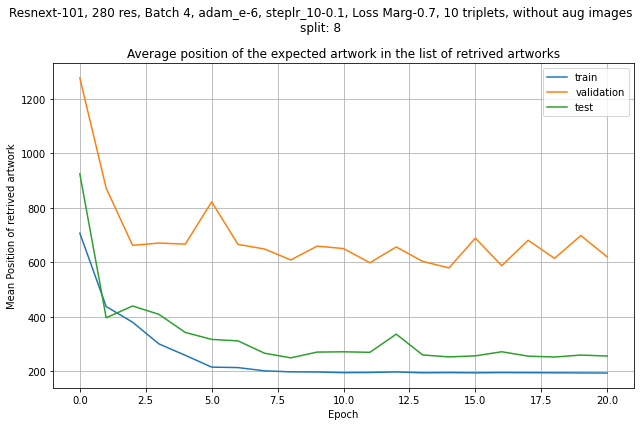

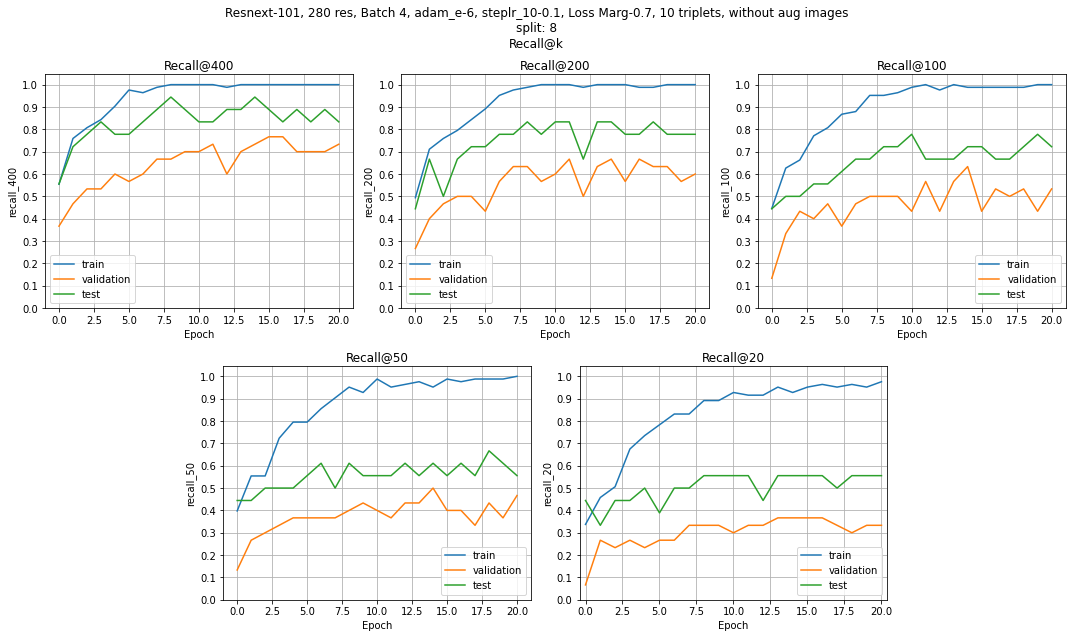

In [21]:
split_id = 8

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [22]:
best_epoch = 14

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v9

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,863.655000,1289.572917,847.098958,0.194033,0.510417,0.447917,0.385417,0.343750,0.291667
1,463.230000,513.229167,454.489583,0.278539,0.708333,0.614583,0.572917,0.500000,0.427083
2,394.185000,368.697917,377.755208,0.325141,0.770833,0.697917,0.666667,0.604167,0.510417
3,296.865000,182.614583,285.078125,0.397346,0.875000,0.822917,0.770833,0.708333,0.625000
4,261.750000,117.958333,252.843750,0.498982,0.895833,0.843750,0.791667,0.760417,0.708333
5,234.745000,70.114583,227.442708,0.561345,0.947917,0.895833,0.864583,0.833333,0.781250
6,229.370000,49.583333,218.854167,0.604338,0.958333,0.927083,0.864583,0.812500,0.770833
7,211.665000,28.385417,206.921875,0.696923,0.968750,0.958333,0.916667,0.854167,0.833333
8,203.550000,20.937500,196.895833,0.705223,0.989583,0.968750,0.927083,0.885417,0.854167
9,202.910000,15.500000,198.145833,0.731732,0.989583,0.958333,0.937500,0.906250,0.875000


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1012.447368,1624.894737,1012.447368,0.176664,0.421053,0.263158,0.210526,0.210526,0.210526
1,615.605263,831.210526,615.605263,0.224030,0.631579,0.578947,0.473684,0.421053,0.315789
2,678.263158,956.526316,678.263158,0.238298,0.631579,0.631579,0.631579,0.631579,0.578947
3,550.921053,701.842105,550.921053,0.350331,0.789474,0.631579,0.578947,0.526316,0.421053
4,477.500000,555.000000,477.500000,0.322098,0.736842,0.684211,0.631579,0.526316,0.473684
5,444.657895,489.315789,444.657895,0.346134,0.684211,0.631579,0.578947,0.526316,0.526316
6,392.684211,385.368421,392.684211,0.313191,0.789474,0.684211,0.631579,0.526316,0.473684
7,369.657895,339.315789,369.657895,0.397388,0.789474,0.736842,0.631579,0.526316,0.473684
8,445.736842,491.473684,445.736842,0.418203,0.736842,0.684211,0.684211,0.684211,0.526316
9,448.447368,496.894737,448.447368,0.331368,0.842105,0.789474,0.684211,0.578947,0.473684


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,712.875000,1025.750000,712.875000,0.177116,0.625000,0.562500,0.500000,0.500000,0.375000
1,394.156250,388.312500,394.156250,0.294481,0.875000,0.687500,0.687500,0.625000,0.625000
2,290.125000,180.250000,290.125000,0.258278,0.875000,0.750000,0.687500,0.625000,0.437500
3,267.343750,134.687500,267.343750,0.378124,0.875000,0.875000,0.750000,0.687500,0.625000
4,280.531250,161.062500,280.531250,0.388102,0.875000,0.812500,0.812500,0.750000,0.625000
5,232.843750,65.687500,232.843750,0.412098,1.000000,0.812500,0.812500,0.687500,0.625000
6,272.093750,144.187500,272.093750,0.403355,0.875000,0.812500,0.812500,0.750000,0.687500
7,215.406250,30.812500,215.406250,0.403092,1.000000,1.000000,0.875000,0.875000,0.500000
8,217.531250,35.062500,217.531250,0.464994,1.000000,1.000000,0.812500,0.812500,0.625000
9,221.187500,42.375000,221.187500,0.444615,1.000000,0.937500,0.875000,0.875000,0.625000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,875.500000,1351.000000,875.500000,0.176871,0.514286,0.400000,0.342857,0.342857,0.285714
1,514.371429,628.742857,514.371429,0.256237,0.742857,0.628571,0.571429,0.514286,0.457143
2,500.828571,601.657143,500.828571,0.247432,0.742857,0.685714,0.657143,0.628571,0.514286
3,421.285714,442.571429,421.285714,0.363036,0.828571,0.742857,0.657143,0.600000,0.514286
4,387.457143,374.914286,387.457143,0.352271,0.800000,0.742857,0.714286,0.628571,0.542857
5,347.828571,295.657143,347.828571,0.376289,0.828571,0.714286,0.685714,0.600000,0.571429
6,337.557143,275.114286,337.557143,0.354409,0.828571,0.742857,0.714286,0.628571,0.571429
7,299.142857,198.285714,299.142857,0.399995,0.885714,0.857143,0.742857,0.685714,0.485714
8,341.414286,282.828571,341.414286,0.439593,0.857143,0.828571,0.742857,0.742857,0.571429
9,344.557143,289.114286,344.557143,0.383138,0.914286,0.857143,0.771429,0.714286,0.542857


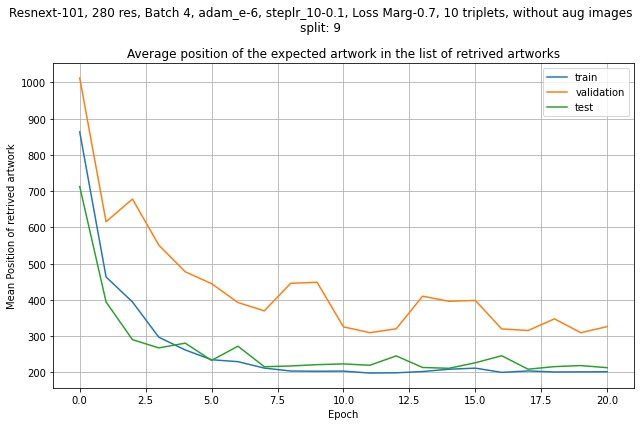

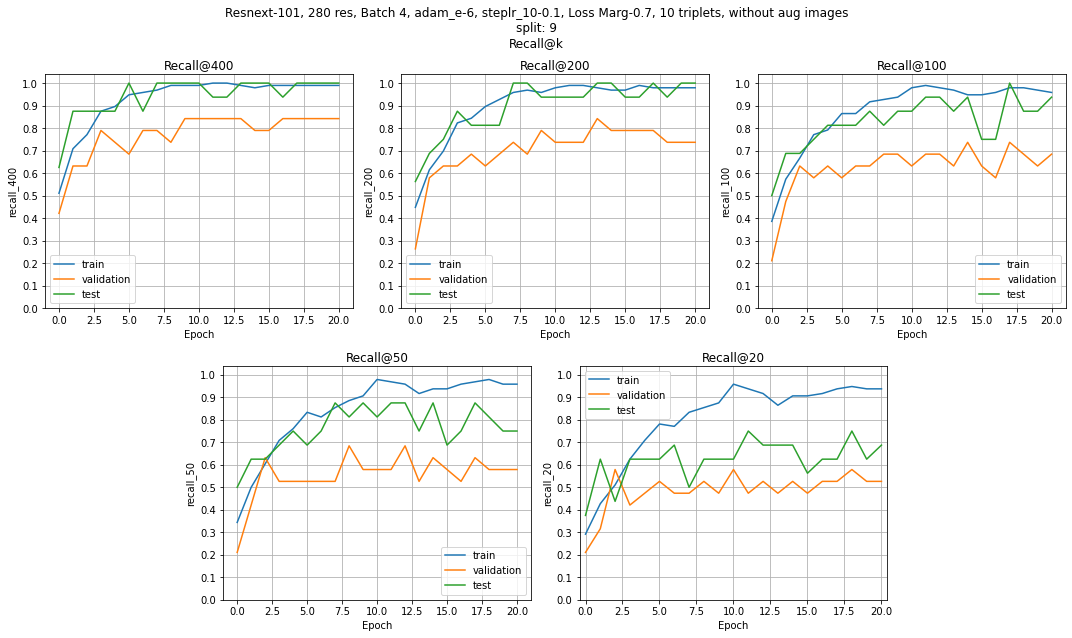

In [23]:
split_id = 9

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [24]:
best_epoch = 11

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

## Data Split - v10

Train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,810.778947,1182.580645,789.118280,0.181839,0.548387,0.483871,0.419355,0.376344,0.311828
1,455.000000,470.387097,437.440860,0.289414,0.731183,0.645161,0.569892,0.494624,0.430108
2,345.452632,270.559140,336.053763,0.381664,0.849462,0.795699,0.741935,0.688172,0.537634
3,293.726316,181.462366,290.860215,0.409115,0.881720,0.838710,0.795699,0.752688,0.688172
4,248.563158,83.645161,241.930108,0.522909,0.935484,0.903226,0.860215,0.817204,0.763441
5,233.210526,64.150538,232.118280,0.615215,0.935484,0.913978,0.892473,0.860215,0.806452
6,227.800000,32.645161,216.344086,0.659536,0.978495,0.946237,0.924731,0.892473,0.860215
7,231.700000,27.838710,213.940860,0.762594,0.956989,0.946237,0.935484,0.935484,0.881720
8,213.857895,7.301075,203.672043,0.773858,0.989247,0.978495,0.967742,0.935484,0.935484
9,214.052632,7.053763,203.548387,0.809469,0.989247,0.978495,0.967742,0.956989,0.935484


Val scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,991.520833,1596.772727,1017.659091,0.184106,0.363636,0.272727,0.227273,0.227273,0.181818
1,656.500000,975.727273,687.818182,0.214293,0.636364,0.500000,0.409091,0.363636,0.272727
2,521.916667,703.272727,546.863636,0.221500,0.681818,0.545455,0.545455,0.454545,0.318182
3,440.812500,522.045455,452.386364,0.222571,0.681818,0.590909,0.500000,0.409091,0.363636
4,441.208333,529.727273,458.818182,0.273809,0.681818,0.636364,0.545455,0.545455,0.454545
5,397.125000,449.636364,403.136364,0.298717,0.727273,0.681818,0.545455,0.545455,0.500000
6,383.937500,382.863636,394.886364,0.288203,0.681818,0.636364,0.590909,0.500000,0.454545
7,431.020833,526.318182,440.022727,0.332350,0.681818,0.681818,0.590909,0.590909,0.545455
8,355.645833,342.227273,363.613636,0.337778,0.727273,0.590909,0.545455,0.500000,0.500000
9,393.250000,409.363636,402.590909,0.269856,0.681818,0.636364,0.545455,0.500000,0.500000


Test scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,1011.718750,1623.437500,1011.718750,0.241018,0.500000,0.375000,0.312500,0.312500,0.312500
1,548.312500,696.625000,548.312500,0.300868,0.750000,0.750000,0.750000,0.625000,0.375000
2,612.468750,824.937500,612.468750,0.266781,0.750000,0.750000,0.750000,0.687500,0.562500
3,578.343750,756.687500,578.343750,0.285413,0.750000,0.750000,0.750000,0.750000,0.500000
4,534.937500,669.875000,534.937500,0.343559,0.750000,0.750000,0.750000,0.687500,0.625000
5,464.125000,528.250000,464.125000,0.340275,0.750000,0.750000,0.750000,0.687500,0.562500
6,406.937500,413.875000,406.937500,0.358742,0.750000,0.750000,0.750000,0.750000,0.687500
7,546.062500,692.125000,546.062500,0.390816,0.812500,0.750000,0.750000,0.750000,0.625000
8,478.125000,556.250000,478.125000,0.362040,0.812500,0.750000,0.750000,0.750000,0.625000
9,549.875000,699.750000,549.875000,0.394276,0.750000,0.750000,0.750000,0.625000,0.625000


Non-train scores


,mean_position,mean_min_position,mean_median_position,map,recall_400,recall_200,recall_100,recall_50,recall_20
0,999.600000,1608.000000,1015.157895,0.208069,0.421053,0.315789,0.263158,0.263158,0.236842
1,613.225000,858.210526,629.078947,0.250746,0.684211,0.605263,0.552632,0.473684,0.315789
2,558.137500,754.500000,574.486842,0.240566,0.710526,0.631579,0.631579,0.552632,0.421053
3,495.825000,620.842105,505.421053,0.249031,0.710526,0.657895,0.605263,0.552632,0.421053
4,478.700000,588.736842,490.868421,0.303177,0.710526,0.684211,0.631579,0.605263,0.526316
5,423.925000,482.736842,428.815789,0.316215,0.736842,0.710526,0.631579,0.605263,0.526316
6,393.137500,395.921053,399.960526,0.317904,0.710526,0.684211,0.657895,0.605263,0.552632
7,477.037500,596.131579,484.671053,0.356967,0.736842,0.710526,0.657895,0.657895,0.578947
8,404.637500,432.342105,411.828947,0.347994,0.763158,0.657895,0.631579,0.605263,0.552632
9,455.900000,531.631579,464.605263,0.322244,0.710526,0.684211,0.631579,0.552632,0.552632


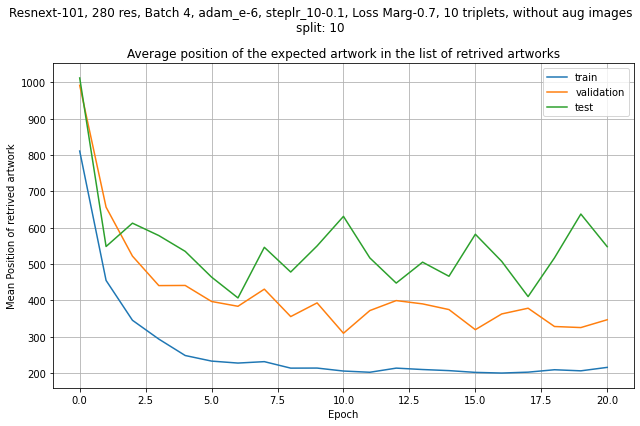

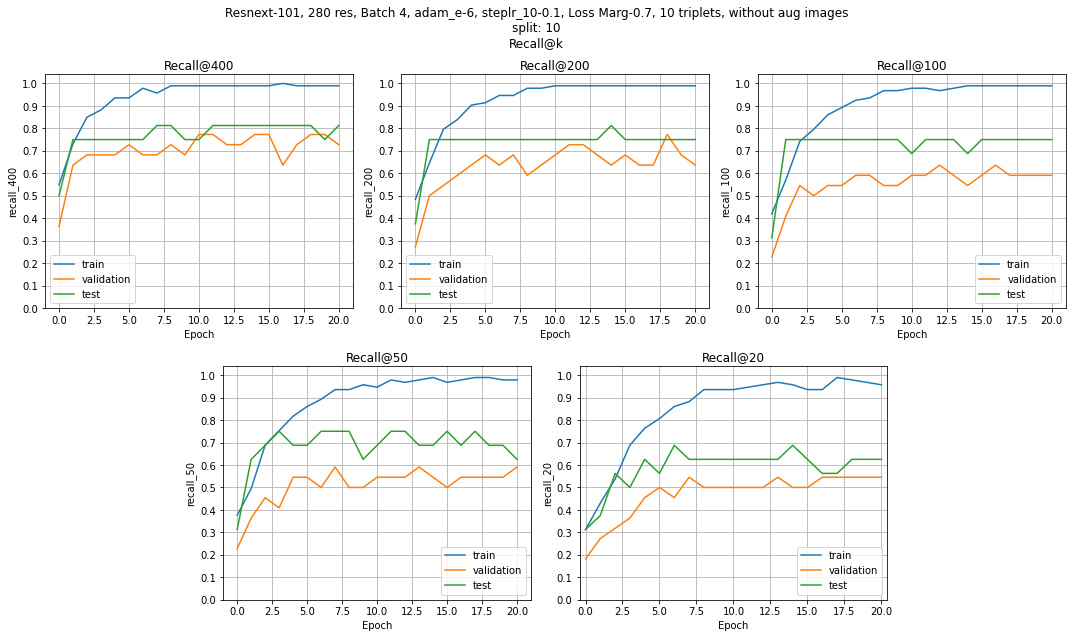

In [25]:
split_id = 10

(train_loss, val_loss,
 train_scores, val_scores, test_scores,
 test_val_scores, lr_df) = read_losses_scores_lr(losses_folder, scores_folder, lr_folder, split_id)

print("Train scores")
highlight_df_scores(train_scores)
print("Val scores")
highlight_df_scores(val_scores)
print("Test scores")
highlight_df_scores(test_scores)
print("Non-train scores")
highlight_df_scores(test_val_scores)

plot_mean_position(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))
plot_recall_at_k(train_scores, val_scores, test_scores, None, train_param + "\nsplit: {}".format(split_id))

In [26]:
best_epoch = 10

train_metrics.append(["FT No-Aug", split_id, best_epoch] + train_scores.loc[best_epoch].values.tolist())
val_metrics.append(["FT No-Aug", split_id, best_epoch] + val_scores.loc[best_epoch].values.tolist())
test_metrics.append(["FT No-Aug", split_id, best_epoch] + test_scores.loc[best_epoch].values.tolist())
non_train_metrics.append(["FT No-Aug", split_id, best_epoch] + test_val_scores.loc[best_epoch].values.tolist())

In [27]:
train_metrics_df = pd.DataFrame(train_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
val_metrics_df = pd.DataFrame(val_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
test_metrics_df = pd.DataFrame(test_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])
non_train_metrics_df = pd.DataFrame(non_train_metrics, columns=["model", "data_split_version", "best_epoch", "MP","MMP", "mean_median_position", 'MAP','R@400', 'R@200', 'R@100', 'R@50', 'R@20'])

In [28]:
train_metrics_df["MAP"] = 100 * train_metrics_df["MAP"]
train_metrics_df["R@400"] = 100 * train_metrics_df["R@400"]
train_metrics_df["R@200"] = 100 * train_metrics_df["R@200"]
train_metrics_df["R@100"] = 100 * train_metrics_df["R@100"]
train_metrics_df["R@50"] = 100 * train_metrics_df["R@50"]
train_metrics_df["R@20"] = 100 * train_metrics_df["R@20"]

val_metrics_df["MAP"] = 100 * val_metrics_df["MAP"]
val_metrics_df["R@400"] = 100 * val_metrics_df["R@400"]
val_metrics_df["R@200"] = 100 * val_metrics_df["R@200"]
val_metrics_df["R@100"] = 100 * val_metrics_df["R@100"]
val_metrics_df["R@50"] = 100 * val_metrics_df["R@50"]
val_metrics_df["R@20"] = 100 * val_metrics_df["R@20"]

test_metrics_df["MAP"] = 100 * test_metrics_df["MAP"]
test_metrics_df["R@400"] = 100 * test_metrics_df["R@400"]
test_metrics_df["R@200"] = 100 * test_metrics_df["R@200"]
test_metrics_df["R@100"] = 100 * test_metrics_df["R@100"]
test_metrics_df["R@50"] = 100 * test_metrics_df["R@50"]
test_metrics_df["R@20"] = 100 * test_metrics_df["R@20"]

non_train_metrics_df["MAP"] = 100 * non_train_metrics_df["MAP"]
non_train_metrics_df["R@400"] = 100 * non_train_metrics_df["R@400"]
non_train_metrics_df["R@200"] = 100 * non_train_metrics_df["R@200"]
non_train_metrics_df["R@100"] = 100 * non_train_metrics_df["R@100"]
non_train_metrics_df["R@50"] = 100 * non_train_metrics_df["R@50"]
non_train_metrics_df["R@20"] = 100 * non_train_metrics_df["R@20"]

In [31]:
train_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_noaug/train_scores_kfold.csv", index=False)
val_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_noaug/val_scores_kfold.csv", index=False)
test_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_noaug/test_scores_kfold.csv", index=False)
non_train_metrics_df.to_csv("./../../../data/model_learning/comparison/scores/fine_tune_noaug/non_train_scores_kfold.csv", index=False)

In [3]:
train_metrics_df= pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_noaug/train_scores_kfold.csv")
val_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_noaug/val_scores_kfold.csv")
test_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_noaug/test_scores_kfold.csv")
non_train_metrics_df = pd.read_csv("./../../../data/model_learning/comparison/scores/fine_tune_noaug/non_train_scores_kfold.csv")

In [4]:
train_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug,0,10,210.278947,19.860215,209.951613,79.935322,97.849462,96.774194,94.623656,92.473118,90.322581
1,FT No-Aug,1,10,208.750000,10.150000,195.175000,79.099108,98.750000,96.250000,96.250000,95.000000,88.750000
2,FT No-Aug,2,10,204.758824,6.890244,198.615854,82.375859,98.780488,97.560976,97.560976,93.902439,90.243902
3,FT No-Aug,3,10,198.820513,2.779221,196.220779,85.698891,100.000000,100.000000,100.000000,98.701299,96.103896
4,FT No-Aug,4,15,199.186747,2.851852,196.907407,79.637371,100.000000,98.765432,98.765432,97.530864,95.061728
5,FT No-Aug,5,10,214.587209,17.481928,203.969880,75.446548,97.590361,96.385542,96.385542,92.771084,87.951807
6,FT No-Aug,6,10,199.164634,8.162500,194.206250,82.400563,100.000000,98.750000,97.500000,95.000000,90.000000
7,FT No-Aug,7,12,198.831579,5.784946,194.655914,82.950807,100.000000,98.924731,98.924731,96.774194,94.623656
8,FT No-Aug,8,14,195.447674,4.951807,188.090361,83.220722,100.000000,100.000000,98.795181,95.180723,92.771084
9,FT No-Aug,9,11,197.985000,3.843750,193.859375,77.349851,100.000000,98.958333,98.958333,96.875000,93.750000


In [5]:
val_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug,0,10,362.825000,362.789474,360.973684,30.087255,73.684211,73.684211,68.421053,63.157895,57.894737
1,FT No-Aug,1,10,289.066667,178.133333,289.066667,23.613723,80.000000,76.666667,66.666667,50.000000,40.000000
2,FT No-Aug,2,10,319.318182,238.636364,319.318182,31.063681,72.727273,63.636364,63.636364,54.545455,45.454545
3,FT No-Aug,3,10,293.533333,206.275862,290.310345,19.996090,82.758621,75.862069,72.413793,58.620690,48.275862
4,FT No-Aug,4,15,285.854839,181.833333,285.950000,18.651879,93.333333,80.000000,63.333333,46.666667,33.333333
5,FT No-Aug,5,10,273.551724,147.103448,273.551724,19.856079,93.103448,75.862069,68.965517,58.620690,37.931034
6,FT No-Aug,6,10,310.600000,145.555556,271.944444,26.090409,77.777778,77.777778,72.222222,66.666667,61.111111
7,FT No-Aug,7,12,449.052632,498.105263,449.052632,30.081480,68.421053,63.157895,42.105263,36.842105,36.842105
8,FT No-Aug,8,14,579.564516,441.900000,434.283333,24.828072,73.333333,66.666667,63.333333,50.000000,36.666667
9,FT No-Aug,9,11,309.421053,218.842105,309.421053,44.389210,84.210526,73.684211,68.421053,57.894737,47.368421


In [6]:
test_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug,0,10,385.475000,389.526316,395.447368,33.042072,89.473684,73.684211,63.157895,57.894737,52.631579
1,FT No-Aug,1,10,332.666667,265.333333,332.666667,35.641651,85.714286,76.190476,71.428571,57.142857,52.380952
2,FT No-Aug,2,10,403.464286,426.814815,407.407407,16.006517,74.074074,62.962963,44.444444,37.037037,22.222222
3,FT No-Aug,3,10,649.018519,446.200000,447.340000,29.689601,72.000000,68.000000,56.000000,44.000000,40.000000
4,FT No-Aug,4,15,479.595238,605.750000,484.175000,33.504478,80.000000,70.000000,65.000000,55.000000,55.000000
5,FT No-Aug,5,10,237.775000,78.052632,240.131579,26.705289,94.736842,84.210526,78.947368,68.421053,63.157895
6,FT No-Aug,6,10,423.287879,446.575758,423.287879,21.120401,63.636364,54.545455,48.484848,39.393939,30.303030
7,FT No-Aug,7,12,622.142857,206.947368,304.052632,33.743741,84.210526,78.947368,73.684211,68.421053,63.157895
8,FT No-Aug,8,14,253.111111,106.222222,253.111111,42.158687,94.444444,83.333333,72.222222,61.111111,55.555556
9,FT No-Aug,9,11,219.468750,38.937500,219.468750,42.953423,93.750000,93.750000,93.750000,87.500000,75.000000


In [7]:
non_train_metrics_df

,model,data_split_version,best_epoch,MP,MMP,mean_median_position,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug,0,10,374.150000,376.157895,378.210526,31.564663,81.578947,73.684211,65.789474,60.526316,55.263158
1,FT No-Aug,1,10,307.019608,214.039216,307.019608,28.566399,82.352941,76.470588,68.627451,52.941176,45.098039
2,FT No-Aug,2,10,366.440000,342.326531,367.857143,22.766876,73.469388,63.265306,53.061224,44.897959,32.653061
3,FT No-Aug,3,10,461.921053,317.351852,363.009259,24.483827,77.777778,72.222222,64.814815,51.851852,44.444444
4,FT No-Aug,4,15,364.096154,351.400000,365.240000,24.592919,88.000000,76.000000,64.000000,50.000000,42.000000
5,FT No-Aug,5,10,258.948980,119.770833,260.322917,22.567225,93.750000,79.166667,72.916667,62.500000,47.916667
6,FT No-Aug,6,10,380.764151,340.333333,369.872549,22.874521,68.627451,62.745098,56.862745,49.019608,41.176471
7,FT No-Aug,7,12,539.925000,352.526316,376.552632,31.912610,76.315789,71.052632,57.894737,52.631579,50.000000
8,FT No-Aug,8,14,459.642857,316.020833,366.343750,31.327053,81.250000,72.916667,66.666667,54.166667,43.750000
9,FT No-Aug,9,11,268.300000,136.600000,268.300000,43.732850,88.571429,82.857143,80.000000,71.428571,60.000000


In [8]:
get_averaged_df(train_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug,203.06 ± 6.15,7.94 ± 5.77,81.0 ± 2.98,99.26 ± 0.93,98.3 ± 1.35,97.78 ± 1.55,95.35 ± 1.95,92.1 ± 2.75


In [9]:
get_averaged_df(val_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug,343.87 ± 92.13,255.88 ± 121.66,26.82 ± 7.24,79.69 ± 8.11,72.29 ± 5.87,64.42 ± 8.44,54.32 ± 8.26,44.99 ± 9.02


In [10]:
get_averaged_df(test_metrics_df)

,model,MP,MMP,MAP,R@400,R@200,R@100,R@50,R@20
0,FT No-Aug,421.56 ± 158.68,352.06 ± 247.3,32.58 ± 8.86,82.46 ± 10.39,74.6 ± 10.77,66.9 ± 13.94,58.61 ± 14.83,51.99 ± 15.53
